## Семинар 4. Hugging Face и BERT

### План

1. Введение в Hugging Face
1. BERT для задачи классификации
    1. Zero-shot
    1. BERT для извлечения признаков

## Hugging Face 🤗

Hugging Face – это компания, которая разрабатывает инструменты и библиотеки для работы с моделями глубинного обучения, особенно в области NLP. Помимо разработок компании, у Hugging Face есть [hub](https://huggingface.co/docs/hub/index), в который любой пользователь может загрузить свою модель, датасет или что-то еще. Вот список основных библиотек, которые нам пригодятся:

1. [`transformers`](https://huggingface.co/docs/transformers/index) – содержит реализации с весами для всех наиболее популярных трансформерных моделей, а так же токенизаторы к ним.
1. [`tokenizers`](https://huggingface.co/docs/tokenizers/index) – библиотека для обучения своих токенизаторов, которой почти _никто не пользуется напрямую_. Лучше брать токенизаторы из `transformers`.
1. [`datasets`](https://huggingface.co/docs/datasets/index) – библиотека для загрузки и обработки всех датасетов из huggingface hub.
1. [`evaluate`](https://huggingface.co/docs/evaluate/index) – хранит реализации огромного числа метрик (возможно, вообще всех) для оценки качества моделей.

В следующих неделях еще пощупаем:
1. [`accelerate`](https://huggingface.co/docs/accelerate/index) – библиотека с трюками для ускорения обучения и примерения моделей.
1. [`bitsandbytes`](https://huggingface.co/docs/bitsandbytes/index) – предназначена для обучения и применения квантизованных моделей.
1. [`peft`](https://huggingface.co/docs/peft/index) – библиотека с методами Parameter-Efficient Fine-tunning.

В общем, библиотек очень много. Главное их преимущество заключается в удобства использования. Все библиотеки могут работать друг с другом и все классы внутри одной библиотеки имеют одинаковый интерфейс.

## `datasets`


Любые датасеты, которые лежат на платформе [Hugging Face](https://huggingface.co/datasets), можно скачать одной строчкой, используя [`load_dataset`](https://huggingface.co/docs/datasets/v2.19.0/en/package_reference/loading_methods#datasets.load_dataset). После этого их можно удобно модифицировать с помощью `map`.

In [1]:
# ! pip3 install datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("fancyzhx/ag_news")
dataset

Using the latest cached version of the dataset since fancyzhx/ag_news couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/alexander/.cache/huggingface/datasets/fancyzhx___ag_news/default/0.0.0/eb185aade064a813bc0b7f42de02595523103ca4 (last modified on Sat Jun  1 17:59:12 2024).


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Посмотрим на то, как работает `map`, а еще сравним скорость Fast и обычного токенизаторов.

In [3]:
from transformers import BertTokenizer, BertTokenizerFast

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer_fast = BertTokenizerFast.from_pretrained("bert-base-uncased")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from functools import partial

def tokenize(tokenizer, sample):
    return tokenizer(sample['text'])

dataset = dataset.map(
    partial(tokenize, tokenizer_fast),
    batched=True,
    num_proc=30,
    desc="Tokenization",
    batch_size=1000,
)

Tokenization (num_proc=30):   0%|          | 0/120000 [00:00<?, ? examples/s]

Tokenization (num_proc=30):   0%|          | 0/7600 [00:00<?, ? examples/s]

In [5]:
dataset = dataset.map(
    partial(tokenize, tokenizer),
    batched=True,
    num_proc=30,
    desc="Tokenization",
    batch_size=1000,
)

Tokenization (num_proc=30):   0%|          | 0/120000 [00:00<?, ? examples/s]

Tokenization (num_proc=30):   0%|          | 0/7600 [00:00<?, ? examples/s]

Быстрый токенизатор оказался примерно в 3 раза быстрее простого.

Функция в `map` всегда должна возвращать словарь. Название ключа станет названием новой колонки.

In [8]:
def get_len(sample):
    return {'len': [len(x) for x in sample['input_ids']]}

dataset_with_lens = dataset.map(
    get_len,
    batched=True,
    num_proc=30,
    desc="Get length",
    batch_size=1000,
)

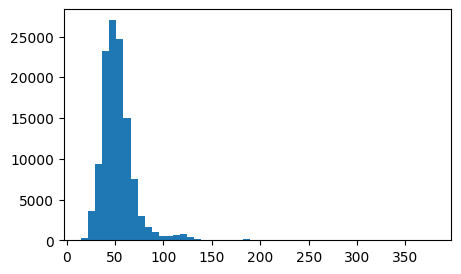

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.hist(dataset_with_lens['train']['len'], bins=50);

Иногда еще полезно бывает поменять тип данных в столбцах датасета.

In [10]:
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset['test'][0]

{'label': tensor(2),
 'input_ids': tensor([  101, 10069,  2005,  1056,  1050, 11550,  2044,  7566,  9209,  5052,
          3667,  2012,  6769,  2047,  8095,  2360,  2027,  2024,  1005,  9364,
          1005,  2044,  7566,  2007, 16654,  6687,  3813,  2976,  9587, 24848,
          1012,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1])}

## Трансформерные модели в Hugging Face

Любую модель вместе с ее весами можно загрузить точно так же, как токенизатор: через `AutoModel` или импортировав конкретный класс.

In [11]:
from transformers import AutoModel

bert_model = AutoModel.from_pretrained('bert-base-uncased')
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Модели по типу BERT часто дообучаются на небольшие задачи: классификация текста, классификация токенов и т.д. От задачи к задаче формат выхода меняется и, соответственно, требуется специальная голова. В `transformers` это все предусмотрено и для каждой задачи есть своя модификация трансформерной модели. При ее загрузке, помимо всего остального, можно указать число классов для предсказания.

__Важно:__ При загрузке модели веса для головы не загружаются (откуда им взяться?). Поэтому такую модель использовать без дообучения не получится.

In [13]:
from transformers import AutoModelForSequenceClassification, AutoModelForTokenClassification, AutoModelForMaskedLM

In [14]:
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)
bert_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Задача классификации

На первой неделе мы учились классифицировать новости из AG-News с помощью простейших методов. Тогда нам удалось получить лучший результат с помощью TF-IDF и линейной модели – 0.92 точности. Попробуем побить это значение, используя большой и сильный BERT.

In [ ]:
# ! pip3 install evaluate

In [ ]:
import numpy as np
import torch
from tqdm.auto import tqdm
import evaluate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Загрузим метрику точности, она понадобится позже.

In [4]:
accuracy_metric = evaluate.load('accuracy')

### Zero-shot

Во время обучения BERT тренируется демаскировать спрятанные от него токены так, чтобы они подходили по смыслу. Значит, если мы сконструируем пример так, чтобы за маской прятался класс в задаче классификации, BERT будет его предсказывать. Такая парадигма применения модели называется __zero-shot__, потому что модель не обучалась ни на одном примере такой классификации.

Загрузим веса BERT для задачи MLM. Они имеются в наличии, так как BERT предобучался именно на эту задачу.

In [19]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Сперва продемонстрируем zero-shot свойства BERT на простом примере.

In [27]:
story_desc = "Elephants are playing in the zoo with monkeys."
prompt = "The story is about [MASK]."

In [28]:
tokenized = tokenizer(f'{story_desc} {prompt}', return_tensors='pt')
tokenized

{'input_ids': tensor([[  101, 16825,  2024,  2652,  1999,  1996,  9201,  2007, 17059,  1012,
          1996,  2466,  2003,  2055,   103,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
output = bert_model(**tokenized)
print(output.logits.shape)

# -3 соответствует токену маски (103)
probs = torch.softmax(output.logits[0, -3], dim=0)
probs, tokens = probs.topk(10)  # Берем 10 наиболее вероятных предсказаний

torch.Size([1, 17, 30522])


In [ ]:
for prob, word in zip(probs, tokenizer.convert_ids_to_tokens(tokens)):
    print(f'{word} \tProb: {round(prob.item(), 3)}')

elephants 	Prob: 0.216
monkeys 	Prob: 0.109
animals 	Prob: 0.086
elephant 	Prob: 0.039
children 	Prob: 0.022
monkey 	Prob: 0.02
birds 	Prob: 0.013
lions 	Prob: 0.013
love 	Prob: 0.01
butterflies 	Prob: 0.009


В целом BERT неплохо справляется с задачей и действительно улавливает контекст.

### `Pipeline`
Для того, чтобы применить модель нам всегда надо сперва токенизировать текст. Для того, чтобы не делать это каждый раз отдельно, можно использовать `pipeline`, в котором токенизация и применение модели объединены. В качестве первого параметра он принимает вид задачи и по нему выбирает подходящий вид модели (если нужный есть).

In [24]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased", device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [25]:
pipe.tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [26]:
pipe.model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Проверим, что результат `pipeline` не отличается от предыдущего.

In [29]:
output = pipe(f'{story_desc} {prompt}', top_k=10)
for out in output:
    print(f'{out["token_str"]} \tProb: {round(out["score"], 3)}')

elephants 	Prob: 0.216
monkeys 	Prob: 0.109
animals 	Prob: 0.086
elephant 	Prob: 0.039
children 	Prob: 0.022
monkey 	Prob: 0.02
birds 	Prob: 0.013
lions 	Prob: 0.013
love 	Prob: 0.01
butterflies 	Prob: 0.009


### Классификация новостей

В любой задаче классификации обычно есть набор фиксированных классов, которые как-то называются. Например, в классификации новостей это _["World", "Sports", "Business", "Sci/Tech"]_.

Мы можем передать список названий классов в `targets`, чтобы `pipeline` возвращал вероятность только для этих классов.

In [30]:
label2name = ["world", "sports", "business", "technology"]
name2label = {v: i for i, v in enumerate(label2name)}

In [31]:
prompt = 'This news is about [MASK].'

prompted_dataset = dataset['test'].map(
    lambda sample: {'text': [f'{text} {prompt}' for text in sample['text']]},
    batched=True,
)
prompted_dataset.set_format(type='torch', columns=['text', 'label'])

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [32]:
def zero_shot_predictions(dataset):
    bs = 32
    predictions = []
    for i in tqdm(range(0, len(dataset), bs)):
        output = pipe(dataset[i:i+bs]['text'], targets=label2name, top_k=1)
        predictions.extend([name2label[out[0]['token_str']] for out in output])

    predictions = np.array(predictions)
    return predictions

In [ ]:
predictions = zero_shot_predictions(prompted_dataset)

In [ ]:
accuracy = accuracy_metric.compute(predictions=predictions, references=prompted_dataset['label'])
accuracy['accuracy']

0.4561842105263158

По какой-то причине точность довольно низкая. Посмотрим на точности по классам.

In [ ]:
per_class_acc = {}
for label in np.unique(prompted_dataset['label']):
    mask = prompted_dataset['label'] == label
    per_class_acc[label2name[label]] = accuracy_metric.compute(
        predictions=predictions[mask],
        references=prompted_dataset['label'][mask]
    )['accuracy']

In [ ]:
per_class_acc

{'world': 0.031578947368421054,
 'sports': 0.5131578947368421,
 'business': 0.9636842105263158,
 'technology': 0.3163157894736842}

Видим, что для некоторых классов точность очень высокая, а для некоторых – очень низкая. Очевидно, названия классов недостаточно хорошо описывают тематику текстов этих классов. Давайте попробуем найти более подходящее название для класса `world`. Для этого посмотрим на самые часто предсказываемые слова для текстов из класса.

In [34]:
world_prompted_dataset = prompted_dataset.filter(
    lambda sample: sample['label'] == name2label['world'],
)
world_prompted_dataset

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1900
})

In [ ]:
from collections import Counter

In [ ]:
bs = 32
top100_words = Counter()
for i in tqdm(range(0, len(world_prompted_dataset), bs)):
    with torch.inference_mode():
        output = pipe(world_prompted_dataset[i:i+bs]['text'], top_k=100)

    for out in output:
        top100_words += Counter([out[j]['token_str'] for j in range(len(out))])

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
top100_words.most_common(20)

[('us', 1896),
 ('it', 1861),
 ('america', 1837),
 ('me', 1821),
 ('you', 1818),
 ('politics', 1726),
 ('news', 1721),
 ('time', 1687),
 ('him', 1651),
 ('china', 1642),
 ('them', 1596),
 ('history', 1474),
 ('canada', 1427),
 ('democracy', 1425),
 ('war', 1408),
 ('life', 1373),
 ('russia', 1348),
 ('freedom', 1343),
 ('terrorism', 1333),
 ('iran', 1328)]

Из 20 самых часто предсказываемых слов больше всего подходит `politics`, поменяем название класса на него.

In [ ]:
label2name = ["politics", "sports", "business", "technology"]
name2label = {v: i for i, v in enumerate(label2name)}

In [ ]:
prompt = 'This news is about [MASK].'

prompted_dataset = dataset['test'].map(
    lambda sample: {'text': [f'{text} {prompt}' for text in sample['text']]},
    batched=True,
)
prompted_dataset.set_format(type='torch', columns=['text', 'label'])

In [ ]:
predictions = zero_shot_predictions(prompted_dataset)

  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
accuracy = accuracy_metric.compute(predictions=predictions, references=prompted_dataset['label'])
accuracy['accuracy']

0.6128947368421053

Ура, сразу стало гораздо лучше.

Этот пример демонстрирует, что BERT действительно умеет в zero-shot. Понятно, что применять его в таком виде довольно глупо, качество никогда не будет высоким. Гораздо лучше всегда дообучать BERT на задачу классификации или хотя бы использовать его выходы как признаки для линейной модели.

## Линейная модель на выходах BERT

BERT обучался на задачу классификации следующего предложения, поэтому в токене [CLS] хранится информация о всем тексте. Будем использовать ее как признаки для линейной модели. Для извлечения выходов [CLS] токена загрузим соответствующую модификацию модели.

In [5]:
from transformers import pipeline

pipe = pipeline("feature-extraction", model="bert-base-uncased", device=device)

In [6]:
def encode_texts(dataset):
    bs = 64
    encodings = []
    for i in tqdm(range(0, len(dataset), bs)):
        output = pipe(dataset[i:i+bs]['text'], return_tensors=True)
        encodings.extend([out[0, 0].cpu() for out in output])

    return encodings

In [ ]:
train_dataset = encode_texts(dataset['train'])
test_dataset = encode_texts(dataset['test'])

У логистической регрессии параметр `multi_class='multinomial'` делает ее мультиклассовой.

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial').fit(train_dataset, dataset['train']['label'])

predictions = model.predict(test_dataset)

/home/amshabalin/anaconda3/envs/karpov/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
accuracy = accuracy_metric.compute(predictions=predictions, references=dataset['test']['label'])
accuracy['accuracy']

0.9005263157894737

Получили довольно высокую точность. Это означает, что BERT самостоятельно извлекает информацию о классе новости, несмотря на то, что мы нигде не учили его делать это в явном виде.